# Pruebas
---
reproducción mínimalista (no entrenamiento, solo carga)

Model loaded from modelParams


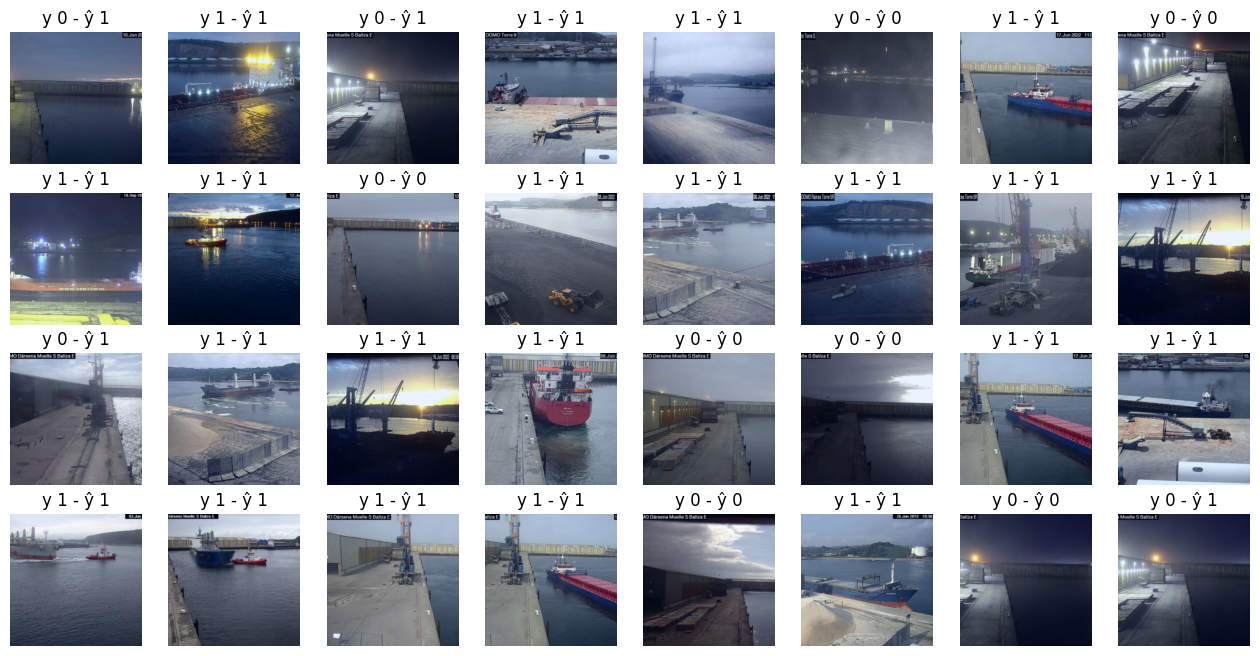

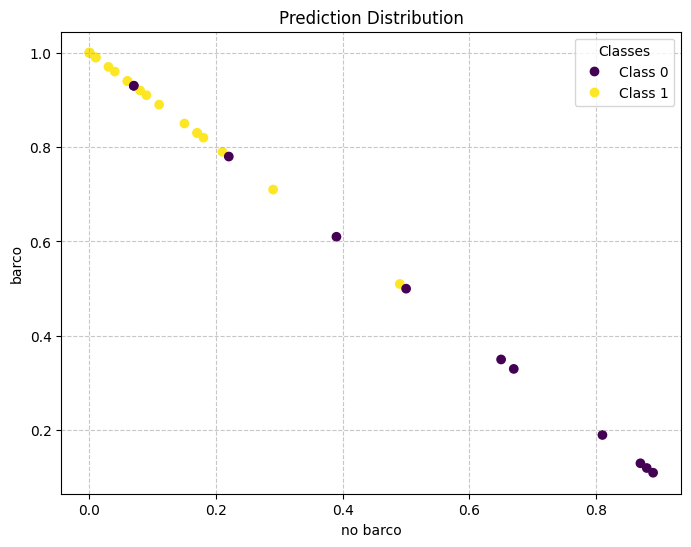

In [2]:
from torch.utils.data import DataLoader
from ship_classifier import ShipClassifier
from ship_dataset import ShipDataset

docked=False
pretrained=False
mlp_head=True
device='mps'
model_path='modelParams'
dataAugmentation=True

classifier = ShipClassifier(pretrained=pretrained,
                            docked=docked,
                            mlp_head=mlp_head,
                            device=device)

classifier.load_model('modelParams')

classifier.model.to('mps')

testset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', 
                      train=False, 
                      dataAugmentation=False, 
                      docked=docked,
                      train_ratio=0.8)

classifier.plotgrid(testset,
                   argmax=True,
                   dataAugmentation=dataAugmentation)

Inferencia de una imagen

label: 1, actual prediction: [0.07240498 0.927595  ]


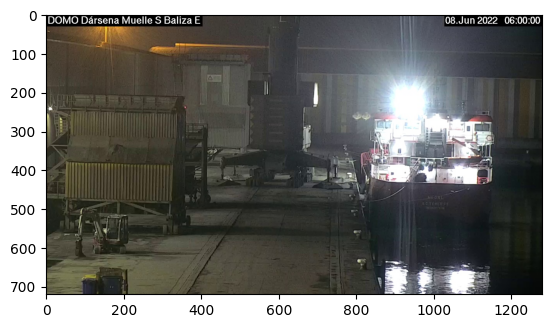

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

im = plt.imread('imagen.jpg')
plt.imshow(im)

#classifier.model.to(device)

im = torch.permute(torch.tensor(np.expand_dims(im,0),dtype=torch.float32),(0,3,1,2)).to('mps')

print(f'label: {np.argmax(classifier.model(im)[0].cpu().detach().numpy())}, actual prediction: {classifier.model(im)[0].cpu().detach().numpy()}')

Visualización del aumento de datos

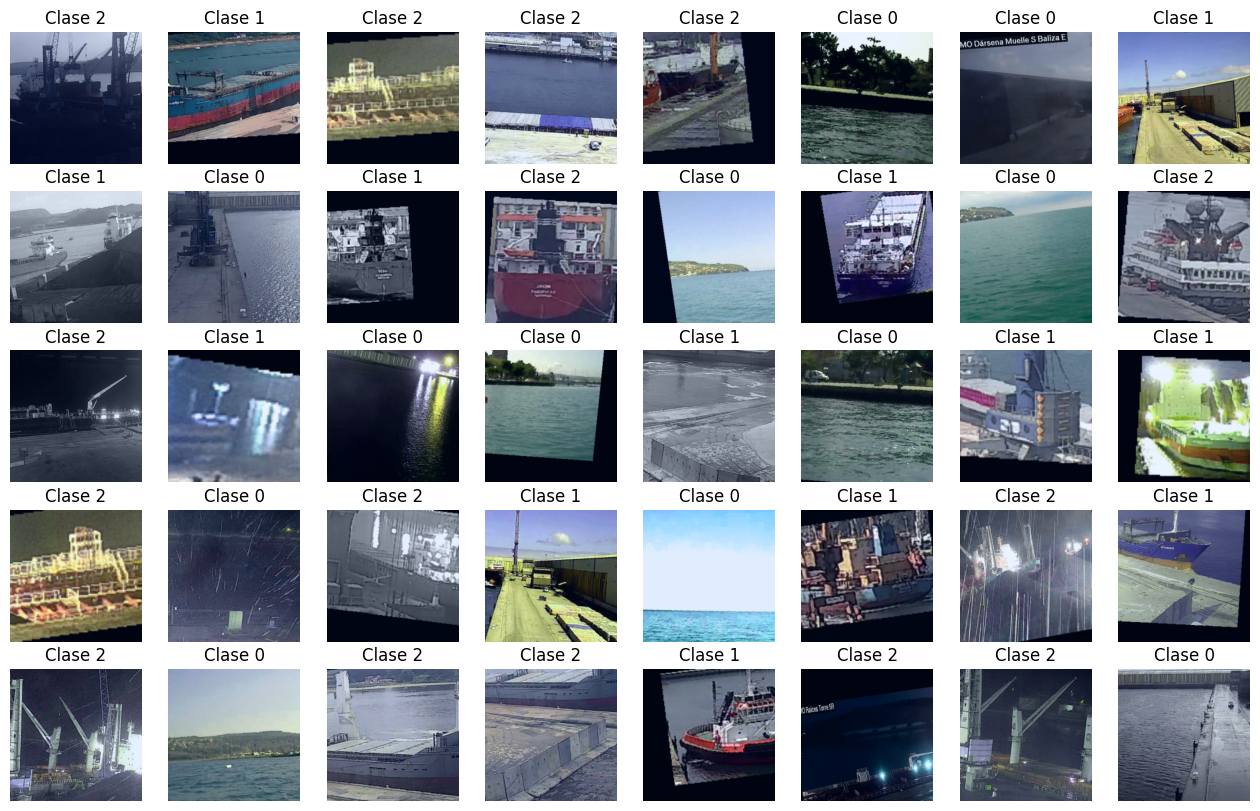

In [2]:
from ship_dataset import ShipDataset

dataAugmentation = True
docked=True
pretrained=False

trainset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', 
                       train=True, 
                       dataAugmentation=dataAugmentation, 
                       docked=docked)

trainset.plot_grid()
